# Table of Contents
* [Submitting HITs](#Submitting-HITs)
	* [Building URLs for images on s3](#Building-URLs-for-images-on-s3)
	* [submitting HITs in groups](#submitting-HITs-in-groups)
		* [creates HITs, careful with this one](#creates-HITs,-careful-with-this-one)
* [Reviewing latest HITs](#Reviewing-latest-HITs)
	* [download](#download)
	* [process](#process)
	* [clustering](#clustering)
		* [The two commands above interact with mechanical turk and can take a while](#The-two-commands-above-interact-with-mechanical-turk-and-can-take-a-while)
* [Merging latest round of HITs into combined dataset](#Merging-latest-round-of-HITs-into-combined-dataset)
	* [Load previously pickled results](#Load-previously-pickled-results)
	* [Load prior complete dataset if not in memory](#Load-prior-complete-dataset-if-not-in-memory)
	* [Updating full dataset](#Updating-full-dataset)
	* [Working with full dataset](#Working-with-full-dataset)
		* [worker specific](#worker-specific)
		* [Reviewing full dataset](#Reviewing-full-dataset)
		* [Sanitizing results- questions marked as answers](#Sanitizing-results--questions-marked-as-answers)
* [Worker analysis](#Worker-analysis)
	* [Basic worker stats](#Basic-worker-stats)
		* [HIT duration for pricing](#HIT-duration-for-pricing)
	* [Identifying high and low consensus workers](#Identifying-high-and-low-consensus-workers)
	* [Messaging workers](#Messaging-workers)
* [HIT end-of-life](#HIT-end-of-life)
	* [Pickle latest results](#Pickle-latest-results)
	* [Pickle combined dataset](#Pickle-combined-dataset)
	* [Accepting and deleting HITs... careful with these](#Accepting-and-deleting-HITs...-careful-with-these)
* [End](#End)


In [415]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import re
from datetime import datetime
import dateutil.parser as dt_parse
import pickle
import boto
import json
import os

from copy import deepcopy
import boto.mturk.connection as tc
import boto.mturk.question as tq
from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes
from keysTkingdom import mturk_aristo

from amt_utils import process_hits as amt_util

# Submitting HITs

## Building URLs for images on s3

In [363]:
turk_data_flat_dir = '/Users/schwenk/wrk/pqa/ai2-vision-turk-data/pqa-annotation/images'

In [360]:
with open('../sunrgbd/rem_image.pkl', 'r') as f:
    remaining_images = pickle.load(f)

In [756]:
image_names = set(remaining_images).intersection(set(imgn.split('.jpg')[0] for imgn in os.listdir(turk_data_flat_dir)))

In [759]:
s3_base = 'https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/pqa-annotation/build/'

def make_hit_url(image_name):
    hit_url = s3_base + 'index.html?url={}'.format(image_name + '.jpg')
    return hit_url

In [774]:
hit_urls = [make_hit_url(image_name) for image_name in image_names if image_name not in pages_done]

In [800]:
for  i in np.random.choice(hit_urls, 10):
    print i

https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/pqa-annotation/build/index.html?url=2014-12-18_14-25-11_260595134347.jpg
https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/pqa-annotation/build/index.html?url=002920_2014-06-26_15-42-34_094959634447_rgbf000081-resize.jpg
https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/pqa-annotation/build/index.html?url=001664_2014-06-20_12-21-18_260595134347_rgbf000139-resize.jpg
https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/pqa-annotation/build/index.html?url=003308_2014-05-15_11-40-15_094959634447_rgbf000101-resize.jpg
https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/pqa-annotation/build/index.html?url=NYU0960.jpg
https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/pqa-annotation/build/index.html?url=0000064-000002152905.jpg
https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/pqa-annotation/build/index.html?url=0000805-000026946864.jpg
https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/pqa-annotation/

In [770]:
pages_done = pd.read_pickle('pages_done.pkl').tolist()

In [771]:
len(pages_done)

912

In [776]:
len(hit_urls)

8235

In [801]:
0.03 * 1.8

0.054

## submitting HITs in groups

In [821]:
## Switch between sandbox and the real world here ##
## DON'T FORGET to change submission POST request in the client ##

sandbox_host = 'mechanicalturk.sandbox.amazonaws.com' 
real_world_host = 'mechanicalturk.amazonaws.com'
mturk = tc.MTurkConnection(
    aws_access_key_id = mturk_aristo.access_key,
    aws_secret_access_key = mturk_aristo.access_secret_key,
    debug = 1, # debug = 2 prints out all requests.
    host = real_world_host
)
current_account_balance = mturk.get_account_balance()[0]
print current_account_balance # a reminder of sandbox

$1,403.04


In [826]:
static_params = {
    'title': "Find attached obects in an image",
    'description': "Select objects in a room that are attached to a surface",
    'keywords': ['image', 'object tagging'],
    'frame_height': 800,
    'amount': 0.06,
    'duration': 3600 * 12,
    'lifetime': 3600 * 24 * 3,
    'max_assignments': 1,
    'response_groups': ['HITDetail'],
    'quals': [new_requirement]
}

In [530]:
expected_cost = len(images_to_submit) *  static_params['amount'] * static_params['max_assignments']
print expected_cost

240.0


In [804]:
attached_qual_build = mturk.create_qualification_type('attached object finding' , 'This is a qualification for finding attached objects in a scene.', status='Active')
attached_qual = attached_qual_build[0]
new_requirement = Requirement(attached_qual.QualificationTypeId, 'EqualTo', integer_value=1)

In [814]:
my_id = 'ATRVCA186WV1B'

In [813]:
set(all_good_workers)

104

In [815]:
for worker in set(all_good_workers + [my_id]):
    mturk.assign_qualification(attached_qual.QualificationTypeId, worker)

### creates HITs, careful with this one

In [1025]:
images_to_submit = hit_urls[2000:6000]
expected_cost = len(images_to_submit) *  static_params['amount'] * static_params['max_assignments']
if float(current_account_balance.amount) < expected_cost:
    print('WARNING -- account balance is too low -- WARNING')
print('expect this batch of HITs to cost: $' + str(expected_cost))

expect this batch of HITs to cost: $240.0


uncomment cell below only when ready to submit

In [827]:
amt_util.create_hits_from_pages(mturk, images_to_submit, static_params)

# Reviewing latest HITs

## download

In [992]:
r_hits_current_batch = amt_util.get_completed_hits(mturk)

In [1005]:
# assignment_results_current_batch = amt_util.get_assignments(mturk, r_hits_current_batch)
assignment_results_current_batch = amt_util.get_assignments(mturk, new_h)

In [1007]:
len(assignment_results_current_batch)

2000

In [920]:
%%time
test_r_hits_current_batch = amt_util.get_completed_hits(mturk)

CPU times: user 388 ms, sys: 20.2 ms, total: 408 ms
Wall time: 17.5 s


In [921]:
len(r_hits_current_batch)

11782

In [914]:
len(test_r_hits_current_batch)

11920

In [960]:
test_hit = test_r_hits_current_batch[-1]

In [965]:
test_r_hits_current_batch = list(mturk.get_all_hits())

In [966]:
len(test_r_hits_current_batch)

13782

In [969]:
test_new_hit = test_r_hits_current_batch[0]

In [970]:
dir(test_new_hit)

['Amount',
 'AssignmentDurationInSeconds',
 'AutoApprovalDelayInSeconds',
 'Comparator',
 'CreationTime',
 'CurrencyCode',
 'Description',
 'Expiration',
 'FormattedPrice',
 'HIT',
 'HITGroupId',
 'HITId',
 'HITReviewStatus',
 'HITStatus',
 'HITTypeId',
 'IntegerValue',
 'Keywords',
 'MaxAssignments',
 'NumberOfAssignmentsAvailable',
 'NumberOfAssignmentsCompleted',
 'NumberOfAssignmentsPending',
 'QualificationRequirement',
 'QualificationTypeId',
 'RequiredToPreview',
 'Reward',
 'Title',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_has_expired',
 'endElement',
 'expired',
 'startElement']

In [997]:
old_h = []
new_h = []
for hit in test_r_hits_current_batch:
    try:
        if hit.MaxAssignments == '1':
            new_h.append(hit)
        else:
            old_h.append(hit)
    except:
        old_h.append(hit)

In [559]:
ta1.SubmitTime

u'2017-02-21T07:16:24Z'

In [593]:
for hit_id, assignments in tag1:
    for assignment in assignments:
        print assignment.SubmitTime

2017-02-22T03:49:18Z
2017-02-22T03:50:13Z
2017-02-22T03:55:01Z


## process group

In [1008]:
group_raw_results = amt_util.process_raw_hits(assignment_results_current_batch)

In [1015]:
group_raw_res_df = amt_util.make_results_df(group_raw_results)

In [1022]:
(group_raw_res_df['category'] == 'Attached').sum()

array([ 0.13911447])

In [1024]:
group_raw_res_df.to_pickle('round_4_qual.pkl')

## process

In [699]:
print 'current assignment statuses'
print amt_util.get_assignment_statuses(assignment_results_current_batch)

current assignment statuses
Submitted    13424
dtype: int64


In [266]:
submitted_assignments = defaultdict(list)
for hitid, assignments in assignment_results_current_batch.items():
    for assignment in assignments:
        if assignment.AssignmentStatus == 'Submitted':
            submitted_assignments[hitid].append(assignment)

In [267]:
len(submitted_assignments)

2338

In [700]:
raw_results = amt_util.process_raw_hits(assignment_results_current_batch)

In [701]:
raw_res_df = amt_util.make_results_df(raw_results)

In [727]:
good_res_df = raw_res_df[raw_res_df['worker_id'].isin(potentially_good_workers)]

In [683]:
raw_res_df['submit_time'] =  pd.to_datetime(raw_res_df['submit_time'])

In [684]:
start_time = pd.Timestamp('2017-02-22 0:0:00')

In [693]:
latest_res_df = good_res_df[good_res_df['submit_time'] > start_time]

In [711]:
# (raw_res_df['submit_time'] > start_time).sum()

In [728]:
consensus_res_df = amt_util.make_consensus_df(good_res_df, 'NO CONSENSUS')

In [731]:
consensus_res_df.to_pickle('combined_round2_3_results.pkl')

In [769]:
pd.Series(pd.unique(consensus_res_df['page'].apply(lambda x: x.split('.jpg')[0]))).to_pickle('pages_done.pkl')

In [730]:
pd.unique(consensus_res_df['page']).shape

(912,)

In [174]:
grouped_by_page = raw_res_df.groupby(['page', 'box_id'])
grouped_by_page.get_group(('0000006-000000268176.jpg', 'T13'))

,page,category,hit_id,assignment_id,box_id,worker_id
2581,0000006-000000268176.jpg,Attached,3MWOYZD5WVPUUX2M7IN8SWG2WSSONH,3DQQ64TANGM5PBLV4LWB1ZT3CN4PWE,T13,AAHY5RYKZHXGZ
2599,0000006-000000268176.jpg,unlabeled,3MWOYZD5WVPUUX2M7IN8SWG2WSSONH,33CID57104UI7S4929S2FL9M9KDL3A,T13,A356GXVAYWN0DV
2617,0000006-000000268176.jpg,unlabeled,3MWOYZD5WVPUUX2M7IN8SWG2WSSONH,3IKZ72A5B4H3B4NNYH9JTM28H5KFNH,T13,A39ZQZ2T5Z7JSB


In [163]:
grouped_by_page = raw_res_df.groupby(['page', 'box_id'])
aggregated_df = grouped_by_page.agg(pd.DataFrame.mode)

In [206]:
raw_res_df.shape

(25974, 6)

In [155]:
raw_res_df['category'].value_counts()['Attached']

2752

In [326]:
grouped_by_page = raw_res_df.groupby(['page', 'box_id'])
aggregated_df = grouped_by_page.agg(lambda x:len(set(x)) == 1)
aggregated_df.drop(['assignment_id', 'worker_id'], axis=1, inplace=True)
aggregated_df = aggregated_df.reset_index()

In [328]:
all_match = aggregated_df[['category']].copy()

In [329]:
consensus_res_df['all_con'] = all_match

In [330]:
consensus_res_df['stringent_category'] = consensus_res_df['category'] * consensus_res_df['all_con']
consensus_res_df['stringent_category'] = consensus_res_df['stringent_category'].replace(r'', 'unlabeled', regex=True)

In [327]:
consensus_res_df = make_consensus_df(raw_res_df, 'NO CONSENSUS')

In [276]:
consensus_res_df['category'].value_counts()

unlabeled    32752
Attached     17169
Name: category, dtype: int64

# Merging latest round of HITs into combined dataset 

## Load previously pickled results

In [383]:
batch_number = 7

with open('./store_hit_results_metadata/group_' + str(batch_number) + '/hit_info.pkl') as f:
    r_hits_previous_batch = pickle.load(f)
    
with open('./store_hit_results_metadata/group_' + str(batch_number) + '/assignment_info.pkl') as f:
    assignment_results_previous_batch = pickle.load(f)
    
# with open('./store_hit_results_metadata/group_' + str(batch_number) + '/raw_res.pkl') as f:
#     raw_hit_results_previous_batch = pickle.load(f)

In [397]:
# combined_results_batch = pd.read_pickle(data_pickled_dir + 'complete_df.pkl')
# combined_consensus_batch = pd.read_pickle(data_pickled_dir + 'consensus_df.pkl')

In [405]:
missing_hits = set(assignment_results_previous_batch.keys()).difference(assignment_results_current_batch.keys())
missing_hits_assignments = {k: v for k, v in assignment_results_previous_batch.items() if k in missing_hits}

## Load prior complete dataset if not in memory

In [2]:
data_pickled_dir = './store_hit_results_metadata/group_latest_combined/' 

In [3]:
combined_results_df = pd.read_pickle(data_pickled_dir + 'complete_df.pkl')
combined_consensus_df = pd.read_pickle(data_pickled_dir + 'consensus_df.pkl')
combined_consensus_with_workerid_df = pd.read_pickle(data_pickled_dir + 'consensus_df_w_workers.pkl') 

## Updating full dataset

In [426]:
combined_results_df = combined_results_df.append(results_df_previous_batch)
combined_consensus_df = combined_consensus_df.append(consensus_prev)
combined_consensus_with_workerid_df = combined_consensus_with_workerid_df.append(consensus_prevww)

In [4]:
%%capture
no_consensus_hits = combined_consensus_df[combined_consensus_df['category'] == 'No Consensus']

## Working with full dataset

### worker specific

In [961]:
flaw_rate = len(no_consensus_hits) / len(combined_consensus_df)
print 'text boxes without consensus are ' + '{0:0.2f}% '.format(flaw_rate * 100) + 'of the total'  

In [255]:
workers_to_qualify = worker_quality_df[worker_quality_df['submitted'] > 100].sort_values('flaw_ratio', ascending= True).head(25).index.tolist()

In [ ]:
workers_to_qualify

In [242]:
bad_and_prolific_workers[:15]

,submitted,incorrect,flaw_ratio
A2KM2RWXQV47CV,2900.0,2093.0,0.721724
A16EEWCUQK9LM2,1069.0,446.0,0.417212
A1QZHZZMO2TE51,582.0,215.0,0.369416
A2XJH3WC02RMXQ,134.0,87.0,0.649254
AQE7EQDM98KB7,154.0,47.0,0.305195
A18DRAESIN3E94,112.0,43.0,0.383929
A8TDOYC7FWWKR,67.0,36.0,0.537313
A9Y1HKUEOOEPM,49.0,35.0,0.714286
A1EGJ4WHHIU61V,45.0,24.0,0.533333
A1ESKJFDQUMBL4,68.0,23.0,0.338235


workers who contacted me

In [256]:
wrote_me = ['A3T8FDBJQV81FN',
'A3UUH3632AI3ZX',
'A2QVMCGDLTWV9',
'A356GXVAYWN0DV',
'A2V4PRG5UBNIX0',
'A333VJ2K6O6R79']

In [258]:
workers_to_ban = bad_and_prolific_workers[:5].index.tolist()
set(bad_and_prolific_workers.index).intersection(set(wrote_me))

{'A2V4PRG5UBNIX0'}

In [275]:
workers_to_ban

[u'A2KM2RWXQV47CV',
 u'A16EEWCUQK9LM2',
 u'A1QZHZZMO2TE51',
 u'A2XJH3WC02RMXQ',
 u'AQE7EQDM98KB7']

In [260]:
combined_consensus_with_workerid_df.head()

,assignment_id,box_id,category,consensus_category,hit_id,page,worker_id
8126,32AT8R96GLAPAZCI12L4EGDHN25US0,T1,unlabeled,unlabeled,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A333VJ2K6O6R79
8144,3WJ1OXY92AHNC6JBHZY8XO1M45D8A9,T1,unlabeled,unlabeled,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A36PFUM96J0ES6
8162,3N2BF7Y2VQVH7ITTH6IJJSPL15VMHP,T1,unlabeled,unlabeled,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A2RSOGTSR83XKO
8131,32AT8R96GLAPAZCI12L4EGDHN25US0,T10,Discussion,Discussion,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A333VJ2K6O6R79
8149,3WJ1OXY92AHNC6JBHZY8XO1M45D8A9,T10,Discussion,Discussion,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A36PFUM96J0ES6


After looking through the top few offenders, it's clear that 

1. the very worst intentionally submitted many blank pages

2. the rest didn't read the directions very closely

3. I'm comfortable rejecting the work of those with > 100 submissions

4. I'll ban the worst 15 from future HITs


### Reviewing full dataset

In [94]:
amt_util.write_results_df(combined_consensus_df, local_result_path)

In [4]:
# all pages from the complete
pages_to_review =pd.unique(combined_consensus_df['page'])

In [5]:
combined_consensus_df[combined_consensus_df['category'] == 'Question'].shape

(16986, 4)

In [6]:
pages_to_review =pd.unique(combined_consensus_df[combined_consensus_df['category'] == 'Question']['page'])

In [7]:
# all pages from the complete dataset with a no-consensus box
# pages_to_review =pd.unique(no_consensus_hits['page'])

In [8]:
sampling_rate = 0.30
sample_size = int(len(pages_to_review) * sampling_rate)
sampled_pages_to_review = list(np.random.choice(pages_to_review, size= sample_size, replace=False))
print 'sampling ' + str(sample_size) + ' pages out of ' + str(len(pages_to_review))
to_review = ['start_seq'] + sampled_pages_to_review

sampling 401 pages out of 1337


In [39]:
overmerged_dir = 'labeled-annotations/'
unmerged_dir = 'annotations_ws/'
lessmerged_dir = 'lessmerged-annotations/'
remerged_annotations  = 'test-remerged-annotations/'
anno_dir = lessmerged_dir
amt_util.review_results(to_review, anno_dir)
print 'posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results'

posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results


In [ ]:
# %%capture 
# # all pages from the latest batch with a no-consensus box

# # suspect_subset = combined_results_df[combined_results_df['worker_id'].isin(bad_and_prolific_to_review[10:15])]
# suspect_subset = combined_results_df[combined_results_df['worker_id'].isin(['A3VE5OH94HYHET'])]
# amt_util.write_results_df(suspect_subset)
# pages_to_review = pd.unique(suspect_subset['page'])

### Sanitizing results- questions marked as answers

In [67]:
question_only_df = combined_consensus_df[combined_consensus_df['category'] == 'Question']

In [68]:
pages_w_questions = pd.unique(question_only_df['page'])
len(pages_w_questions)

1337

In [69]:
combined_df_question_pages_only = combined_consensus_df[combined_consensus_df['page'].isin(pages_w_questions)]

In [111]:
combined_df_question_pages_only.to_pickle('pages_w_questions.pkl')

In [70]:
question_pages_w_answers = pd.unique(combined_df_question_pages_only[combined_df_question_pages_only['category'] == 'Answer']['page'])

In [71]:
question_pages_w_answers.shape

(49,)

In [72]:
incorrectly_marked_answers_df = combined_consensus_df[combined_consensus_df['page'].isin(question_pages_w_answers)]

In [73]:
pd.unique(incorrectly_marked_answers_df['page']).shape

(49,)

In [83]:
to_correct_aq_df = combined_consensus_df[combined_consensus_df['page'].isin(incorrectly_marked_answers_df['page'])]

In [88]:
corrected_aq_df = to_correct_aq_df.replace('Answer', 'Question')

In [105]:
local_result_path='./ai2-vision-turk-data/textbook-annotation-test/corrected_raw_hit_results/'
# local_result_path='./ai2-vision-turk-data/textbook-annotation-test/corrected_unmerged/'

amt_util.write_results_df(corrected_aq_df, local_result_path)

In [106]:
pages_to_review = pd.unique(corrected_aq_df['page'])
sampling_rate = 1
sample_size = int(len(pages_to_review) * sampling_rate)
sampled_pages_to_review = list(np.random.choice(pages_to_review, size= sample_size, replace=False))
print 'sampling ' + str(sample_size) + ' pages out of ' + str(len(pages_to_review))
to_review = ['start_seq'] + sampled_pages_to_review

sampling 49 pages out of 49


In [109]:
# anno_dir = 'corrected_unmerged/'
anno_dir = 'test-remerged-annotations/'

amt_util.review_results(to_review, anno_dir)
print 'posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results'

posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results


# Worker analysis

## Basic worker stats

In [393]:
print 'number of unique workers:'
pd.unique(raw_res_df['worker_id'])

number of unique workers:


array([u'A1UCIW7WR7BTP6', u'AV08M1RKIW8P2', u'A3G2NE6QE5W5R',
       u'A1YQH72YL8YOXN', u'A2CXEAMWU2SFV3', u'A2QSXP571QQRXN',
       u'A4PRXDCEFH48W', u'A2X7BE2FSPUKCK', u'AR50UBGSH10FJ',
       u'A3R6KO03P9QLNO', u'A19ISUEMCS9YNE', u'AC4QQ86BQSCJO',
       u'A1WRE30O3ADISQ', u'AATL9DKBHXYW9', u'A1GF32JTYSL69K',
       u'A1J8Y204VZNWQW', u'A3DKW5X4Y1Z6UD', u'A3CLWSYATO0L5C',
       u'A19DYY1W1EO5EB', u'A1P3Z24Y6GRNVA', u'A1P3YDRJGXWPDT',
       u'A2D3TM156X7Y61', u'A3QZMGTVA4VO44', u'A2AAFF98K5098F',
       u'A2OW0W5J768MIQ', u'AYLD14EI9Q925', u'A3LFWM03CO0Y5',
       u'A3FPQGM967TJER', u'A1HFKYFW5AG80B', u'A1WV72QNKLU22O',
       u'A3UE49REX108ZE', u'A2LD0G04R6MNX7', u'A1IOMFFEKCWOIT',
       u'A13166BUJ0H61J', u'A137K3V6O4ALWB', u'A3TMON68ZR4U84',
       u'A5N6QK76RTR7R', u'AQ4SMD5QQ81C', u'AI31VA94GERPK',
       u'A374KIAMAMZT59', u'AGPGCMNDSKZGT', u'AAHY5RYKZHXGZ',
       u'A3PKDTMMBNJP4L', u'A8SNALQ3K98RB', u'A38NFX88VZDMJ3',
       u'AA524FVH76YFT', u'AZFK7ZGWR5QTL', u'A23EZQCJD0

In [384]:
grouped_by_worker = raw_res_df.groupby('worker_id')

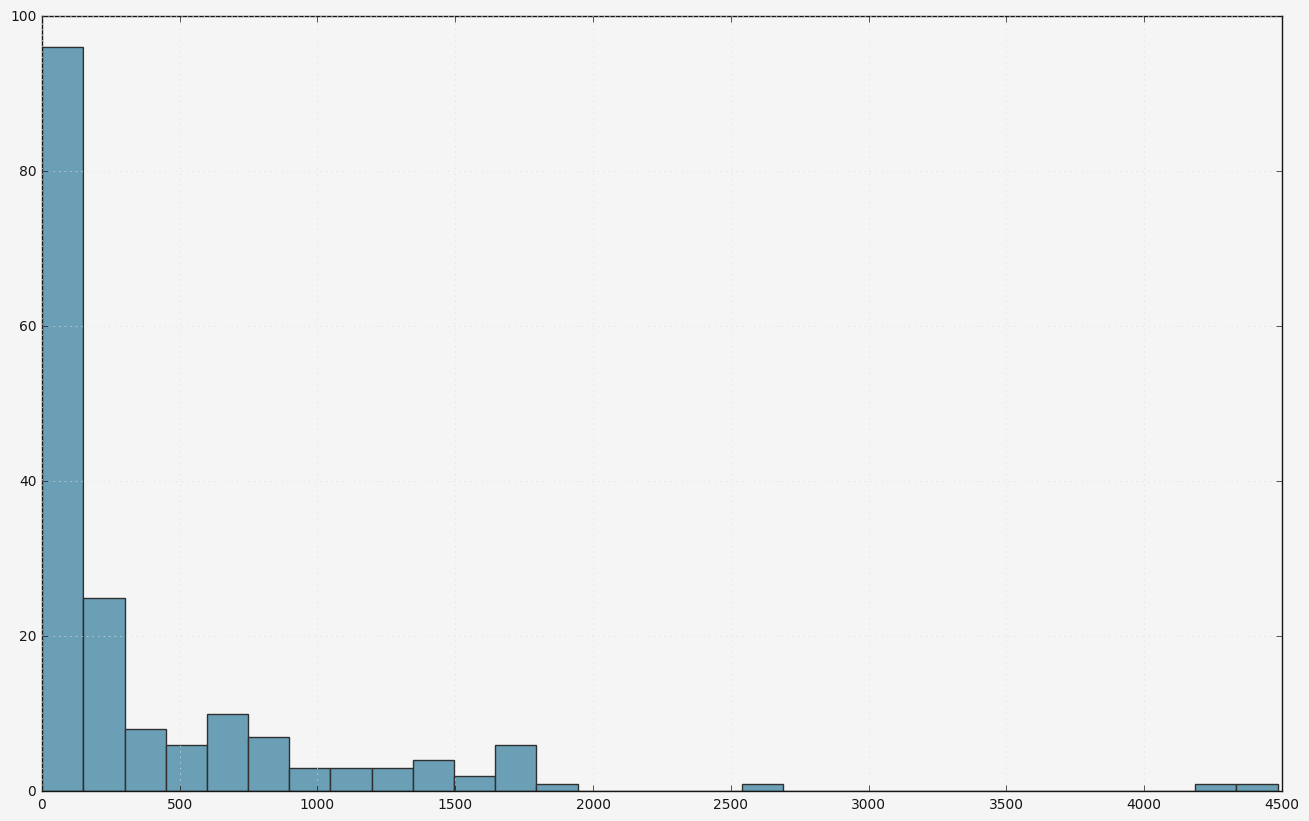

In [1716]:
_ = results_df['worker_id'].value_counts().hist(bins= 30)

### HIT duration for pricing

In [406]:
task_duration_seconds = []
for hit_id, assignments in assignment_results_current_batch.items():
    for assignment in assignments:
        hit_duration = dt_parse.parse(assignment.SubmitTime) - dt_parse.parse(assignment.AcceptTime)
        task_duration_seconds.append(hit_duration.seconds)

In [407]:
task_duration_series = pd.Series(task_duration_seconds)

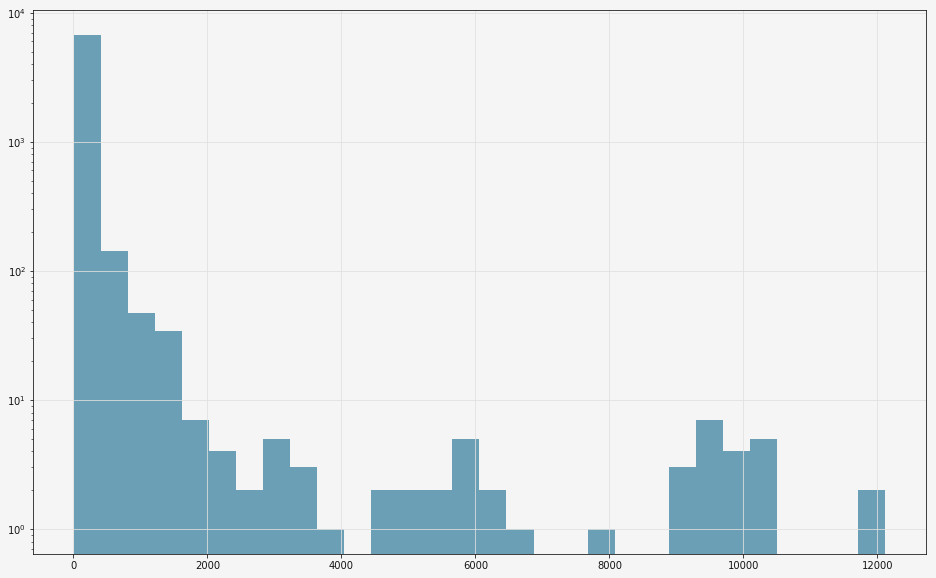

In [408]:
_ = task_duration_series.hist(bins=30, log=True)

In [409]:
winsorized_durations = [t for t in task_duration_seconds if t < 300]
w_duration_series = pd.Series(winsorized_durations)

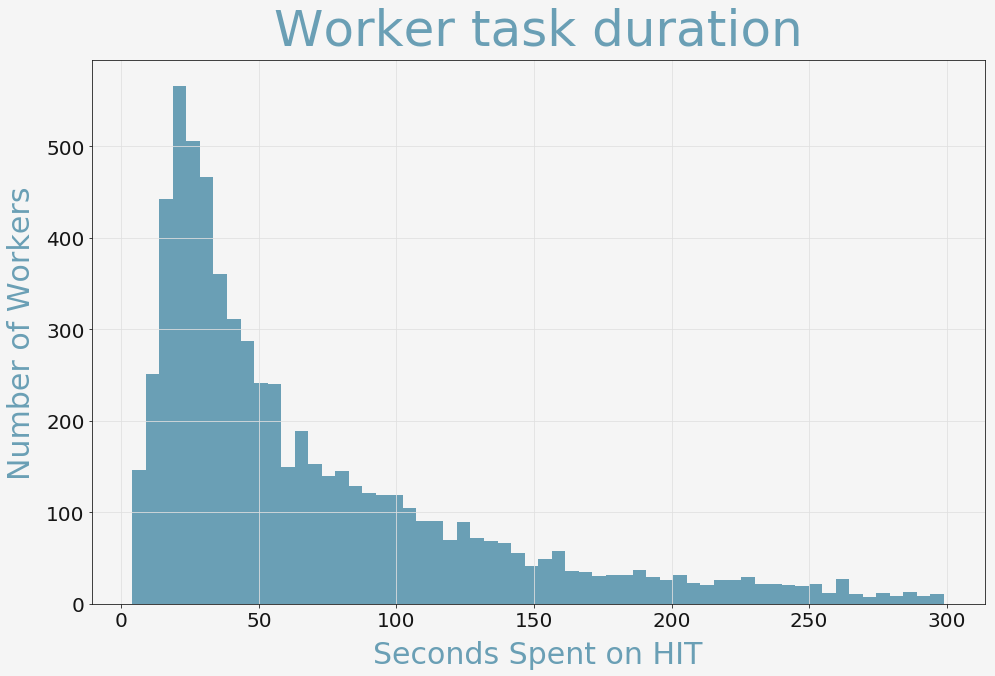

In [410]:
_ = pd.Series(w_duration_series).hist(bins=60)
plt.title('Worker task duration', fontsize=50, verticalalignment='bottom', color = b16_colors.b)
plt.ylabel("Number of Workers", fontsize=30, labelpad=10, color = b16_colors.b)
plt.xlabel("Seconds Spent on HIT", fontsize=30, labelpad=10, color = b16_colors.b)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)

In [438]:
pd.Series(w_duration_series)


0        32
1        25
2        25
3        41
4       102
5        21
6        24
7       187
8       247
9        98
10       14
11       16
12       27
13       27
14      214
15        9
16       24
17       24
18      140
19       20
20       98
21      108
22      158
23      113
24       50
25       80
26      127
27       19
28       18
29       16
       ... 
6538     26
6539     45
6540     90
6541     19
6542    100
6543    162
6544     53
6545     64
6546     52
6547    116
6548     77
6549     99
6550    171
6551     45
6552     15
6553     23
6554      7
6555     46
6556     44
6557     23
6558     15
6559     46
6560     59
6561     94
6562    150
6563     34
6564    132
6565    160
6566     24
6567     81
dtype: int64

In [411]:
print 'duration mode= ' + str(w_duration_series.mode().values[0])
print 'duration median= ' + str(w_duration_series.median())

duration mode= 23
duration median= 47.0


## Identifying high and low consensus workers

In [647]:
consensus_with_workerid_df_this_batch = amt_util.make_consensus_df_w_worker_id(latest_res_df, consensus_res_df)

In [651]:
len(pd.unique(worker_conflicts['worker_id']))

78

In [656]:
worker_conflicts = consensus_with_workerid_df_this_batch[consensus_with_workerid_df_this_batch['category_x'] != consensus_with_workerid_df_this_batch['category_y']]
all_worker_counts = latest_res_df['worker_id'].value_counts()
bad_worker_counts = worker_conflicts['worker_id'].value_counts()
worker_quality_df = pd.DataFrame([all_worker_counts, bad_worker_counts]).T
worker_quality_df.columns=['submitted', 'incorrect']
worker_quality_df['flaw_ratio'] = worker_quality_df['incorrect']/worker_quality_df['submitted']

good_workers = worker_quality_df.sort_values('flaw_ratio', ascending= True).index.tolist()

suspect_workers = worker_quality_df.sort_values('flaw_ratio', ascending= False).index.tolist()

worker_quality_df.sort_values('flaw_ratio', ascending= False).head(10)

,submitted,incorrect,flaw_ratio
A2M5VW97GIYLHB,255.0,104.0,0.407843
A3PC0IDUS9FQA4,180.0,67.0,0.372222
A41IPBF6AJGI9,689.0,255.0,0.370102
A2U8PL0H9LR2BP,434.0,159.0,0.366359
A399B3HHN9ZENF,36.0,13.0,0.361111
A1JAW8YSR4LM8N,64.0,22.0,0.343750
A25OEVVN0293PO,253.0,82.0,0.324111
A1WV72QNKLU22O,1664.0,533.0,0.320312
A3DKW5X4Y1Z6UD,13.0,4.0,0.307692
A3LFWM03CO0Y5,52.0,15.0,0.288462


I became concerned that I missed the perfect performers, but as I suspected perfect workers only did 1-2 HITs at most

In [657]:
pd.DataFrame(top_10_prolific).index

Index([u'A2CXEAMWU2SFV3', u'A3G2NE6QE5W5R', u'A1IOMFFEKCWOIT',
       u'A19ISUEMCS9YNE', u'A3R6KO03P9QLNO', u'A34QZDSTKZ3JO9',
       u'A2LD0G04R6MNX7', u'A2P0QCBK21MA3F', u'A2DXIQTO5DJSUH',
       u'A356GXVAYWN0DV'],
      dtype='object')

In [658]:
worker_quality_df.merge(pd.DataFrame(top_10_prolific), left_index=True, right_index=True)

,submitted,incorrect,flaw_ratio,worker_id
A2CXEAMWU2SFV3,20015.0,3058.0,0.152785,20015
A3G2NE6QE5W5R,15888.0,2254.0,0.141868,15888
A1IOMFFEKCWOIT,13050.0,2080.0,0.159387,13050
A19ISUEMCS9YNE,8938.0,1125.0,0.125867,8938
A3R6KO03P9QLNO,6196.0,1055.0,0.170271,6196
A34QZDSTKZ3JO9,4461.0,612.0,0.137189,4461
A2LD0G04R6MNX7,4089.0,803.0,0.196381,4089
A2P0QCBK21MA3F,3975.0,787.0,0.197987,3975
A2DXIQTO5DJSUH,3675.0,491.0,0.133605,3675
A356GXVAYWN0DV,3569.0,429.0,0.120202,3569


In [716]:
all_worker_counts = raw_res_df['worker_id'].value_counts()
top_10_prolific = all_worker_counts[:10]

In [717]:
grouped_by_worker = raw_res_df.groupby('worker_id')

worker_attached_counts = pd.DataFrame(grouped_by_worker['category'].agg(lambda x: sum(x == 'Attached') / len(x)))

worker_answers_and_fracts = worker_attached_counts.merge(pd.DataFrame(all_worker_counts), left_index=True, right_index=True)
worker_answers_and_fracts.columns = ['fract_attached', 'submissions']

In [719]:
potentially_good_workers = worker_answers_and_fracts[(worker_answers_and_fracts['fract_attached'] < 0.2) & (worker_answers_and_fracts['fract_attached'] > 0.05 )].index.tolist()

In [720]:
len(potentially_good_workers)

74

In [725]:
with open('good_workers.txt', 'w') as f:
    with_nl = map(lambda x: x + '\n', potentially_good_workers)
    f.writelines(with_nl)

In [679]:

worker_answers_and_fracts[worker_answers_and_fracts['fract_attached'] < 0.2].head(20)

,fract_attached,submissions
A19ISUEMCS9YNE,0.078346,8938
A34QZDSTKZ3JO9,0.137637,4461
A2DXIQTO5DJSUH,0.141509,3675
A356GXVAYWN0DV,0.113477,3569
A3BVPQFBYGWJWX,0.109097,2759
A39ZQZ2T5Z7JSB,0.189893,2533
A38NFX88VZDMJ3,0.159273,2473
A10VZBZZUJB632,0.161823,1514
A311JUG8NMVCGU,0.158741,1446
A3EQYMOLG133QS,0.172797,1169


In [952]:
potentially_reject_workers = set(worker_answers_and_fracts[worker_answers_and_fracts['fract_attached'] > 0.5].index)
len(potentially_reject_workers)

36

In [839]:
worker_answers_and_fracts.shape

(190, 2)

In [883]:
len(potentially_reject_workers.union(set(all_good_workers)))

140

In [ ]:
raw_res_df['worker_id']

In [926]:
neither_good_nor_bad_workers = raw_res_df[~raw_res_df['worker_id'].isin(potentially_reject_workers.union(set(all_good_workers)))]

In [927]:
pd.unique(neither_good_nor_bad_workers['assignment_id']).shape

(8732,)

In [928]:
pd.unique(raw_res_df['assignment_id']).shape

(13196,)

In [954]:
bad_workers = raw_res_df[raw_res_df['worker_id'].isin(potentially_reject_workers)]

In [955]:
pd.unique(bad_workers['assignment_id']).shape[0] * 0.03

33.39

In [906]:
raw_res_df['worker_id']

0         A2CXEAMWU2SFV3
1         A2CXEAMWU2SFV3
2         A2CXEAMWU2SFV3
3         A2CXEAMWU2SFV3
4         A2CXEAMWU2SFV3
5         A2CXEAMWU2SFV3
6         A2CXEAMWU2SFV3
7         A2CXEAMWU2SFV3
8         A2CXEAMWU2SFV3
9         A2CXEAMWU2SFV3
10        A2CXEAMWU2SFV3
11        A2CXEAMWU2SFV3
12        A2CXEAMWU2SFV3
13        A2CXEAMWU2SFV3
14        A2CXEAMWU2SFV3
15        A2CXEAMWU2SFV3
16        A3R6KO03P9QLNO
17        A3R6KO03P9QLNO
18        A3R6KO03P9QLNO
19        A3R6KO03P9QLNO
20        A3R6KO03P9QLNO
21        A3R6KO03P9QLNO
22        A3R6KO03P9QLNO
23        A3R6KO03P9QLNO
24        A3R6KO03P9QLNO
25        A3R6KO03P9QLNO
26        A3R6KO03P9QLNO
27        A3R6KO03P9QLNO
28        A3R6KO03P9QLNO
29        A3R6KO03P9QLNO
               ...      
273906     A4PRXDCEFH48W
273907     A4PRXDCEFH48W
273908     A4PRXDCEFH48W
273909     A4PRXDCEFH48W
273910     A4PRXDCEFH48W
273911     A4PRXDCEFH48W
273912     A4PRXDCEFH48W
273913     A4PRXDCEFH48W
273914     A4PRXDCEFH48W


## Messaging workers

In [828]:
subject = "more Attached object HITs"
message = """
Hello everyone, 

Thanks for participating in my last set of HITs. I've now restricted these to the top performers on previous tasks. You should have gotten an email notification about reveiving the qualification.
I've submitted another group of HITs with a higher value to reflect this, and with more to follow in the next few days. 

I'll try to answer questions I've received (sorry, I can't answer them individually):

If you're getting this message, you're finding about the right number of attached objects in the image. Just to say again, 
an attached object should require breaking some kind of connection (nails, bolts, screws, glue) to move it. This includes softer connections like a picture hanging on a wall, 
but not an object that only touches another. If a particular object is unclear, please leave it unmarked.

You don't have to mark the floors and walls themselves (only objects attached to them).

Not every object is selectable. You only have to mark the ones that have a box around them when you mouse over them.

Thanks again everyone for the good work.
"""

In [806]:
contacted_me = 'A3D0B5IL447G74'
m2 ='A5N6QK76RTR7R'

In [794]:
with open('./good_workers.txt', 'r') as f:
    all_good_workers = f.readlines()
    all_good_workers = [w.strip() for w in all_good_workers]

In [833]:
# _ = mturk.notify_workers(all_good_workers[100:], subject, message)

# HIT end-of-life

## Pickle latest results

In [212]:
#reset as needed
gn = 1

In [834]:
gn

2

In [835]:
next_group = gn + 1
group_n = '_' + str(gn) + '/'

temp_store_dir = './store_hit_results_metadata/group'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
result_file_name = 'hit_info.pkl'
assignment_file_name = 'assignment_info.pkl'
raw_results_file_name = 'raw_res.pkl'
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'

amt_util.pickle_this(r_hits_current_batch, temp_store_dir + group_n + result_file_name)
amt_util.pickle_this(assignment_results_current_batch, temp_store_dir + group_n + assignment_file_name)
amt_util.pickle_this(raw_hit_results_current_batch, temp_store_dir + group_n + raw_results_file_name)
raw_res_df.to_pickle(temp_store_dir + group_n + complete_results_file)
print 'saved HIT batch number ' + str(gn)
print 'now onto batch ' +str(next_group) 
gn = next_group

saved HIT batch number 2
now onto batch 3


## Pickle combined dataset

In [210]:
temp_store_dir = './store_hit_results_metadata/group'
group_n = '_latest_combined/'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'
consensus_results_file_w_workers = 'consensus_df_w_workers.pkl'

combined_results_df.to_pickle(temp_store_dir + group_n + complete_results_file)
combined_consensus_df.to_pickle(temp_store_dir + group_n + consensus_results_file)
combined_consensus_with_workerid_df.to_pickle(temp_store_dir + group_n + consensus_results_file_w_workers)

NameError: name 'combined_results_df' is not defined

## Accepting and deleting HITs... careful with these

Uncomment only when ready to accept or delete hits

reject assignments carefully

In [336]:
all_hits = list(mturk.get_all_hits())

In [337]:
len(all_hits)

9782

In [339]:
test_hit = all_hits[0]

In [342]:
test_hit.HITId

u'3RQVKZ7ZRKFK7EUBFI3ANVLM82X72B'

In [345]:
for a_hit in all_hits:
    mturk.expire_hit(a_hit.HITId)

In [ ]:
for hid in all_hits:
    boto.

In [321]:
# number_rejected_assignments, number_rejected_workers = amt_util.reject_assignments(mturk, workers_to_ban, combined_consensus_with_workerid_df)
# print 'rejecting ' + str(number_rejected_assignments) + ' assignments' + ' from ' + str(number_rejected_workers) + ' workers'

In [1752]:
len()

3

In [778]:
len(assignment_results_current_batch)

11782

In [783]:
len(potentially_good_workers)

74

In [786]:
assigment_count = 0
for hit_id, hit_assignments in list(assignment_results_current_batch.items()):
    for assignment in hit_assignments:
        if assignment.AssignmentStatus == 'Submitted':
            if assignment.WorkerId in potentially_good_workers:
                assigment_count += 1

In [788]:
good_worker_assignments = [item for sublist in assignment_results_current_batch.values() for item in sublist if item.WorkerId in potentially_good_workers]

In [790]:
# flattened_assignments = [item for sublist in assignment_results_current_batch.values() for item in sublist]

# len(flattened_assignments)

# # amt_util.get_assignment_statuses(assignment_results_current_batch)

# amt_util.get_assignment_statuses(assignment_results_current_batch)

# amt_util.accept_hits(mturk, flattened_assignments)

amt_util.accept_assignments(mturk, good_worker_assignments)

In [259]:
len(flattened_assignments)

1302

In [437]:
# amt_util.delete_some_hits(mturk, assignment_results_current_batch_post_)

In [100]:
# amt_util.delete_all_hits(mturk)

# End

In [ ]:
def area_intersect_over_union(segmentImage1, segmentImage2, segmentArea1 = 0, segmentArea2 = 0):
    areaIntersection = np.sum(segmentImage1 & segmentImage2)
    if areaIntersection == 0:
        return 0, 0, 0
    if segmentArea1 == 0:
        segmentArea1 = np.sum(segmentImage1)
    if segmentArea2 == 0:
        segmentArea2 = np.sum(segmentImage2)
    areaOverlap = areaIntersection / (segmentArea1 + segmentArea2 - areaIntersection + 0.01)
    areaSelfOverlap1 = areaIntersection / (segmentArea1 + 0.01)
    areaSelfOverlap2 = areaIntersection / (segmentArea2 + 0.01)
    return areaOverlap, areaSelfOverlap1, areaSelfOverlap2


def comp_iou(raw_image, ocr_box, anno_box):

    def update_img(mask, box):
        # box
        # some rectangle of the structure [[start_x, start_y], [end_x, end_y]
        start_x, start_y = box[0]
        end_x, end_y = box[1]
        mask[start_y:end_y + 1, start_x:end_x + 1] = True

    mask_a = np.zeros(raw_image.shape[0:2], dtype=np.bool)
    mask_b = np.zeros(raw_image.shape[0:2], dtype=np.bool)
    update_img(mask_a, ocr_box['rectangle'])
    update_img(mask_b, anno_box['rectangle'])

    areaOverlap, areaSelfOverlap1, areaSelfOverlap2 = areaIntersectOverUnion(mask_a, mask_b)

    #iou = (mask == 2).sum() / (mask >= 1).sum()
    return areaOverlap, areaSelfOverlap1, areaSelfOverlap2 

In [ ]:
problem_name = 'continental_drift_9076.png'
problem = diagram_locs[problem_name]


image_path = flattened_topic_dir + problem_name
drawn_image = draw_clusters(image_path, clustered_text_boxes_centers)
Image.fromarray(drawn_image)

[clust for clust in clustered_text_boxes_centers if len(clust) < 3]

len (clustered_text_boxes)

for box in clustered_text_boxes:
    print box
    print

In [ ]:
# def find_overlapping_boxes(user_boxes):
#     for user in range(1, len(user_boxes)):
#         for box1 in user_boxes[0]:
#             for box2 in sorted(user_boxes[user]):
#                 biou = comp_boxes_iou(box1, box2)
#                 if biou > 0.5
#                     print biou
# #         print